# Wavelet & Time-Frequency Analysis Notebook

## 1. Short-Time Fourier Transform (STFT) — Theory

The Short-Time Fourier Transform is a method to analyze how the frequency content of a signal changes over time. Instead of applying the Fourier Transform to the whole signal at once, STFT divides the signal into short overlapping windows and computes a Fourier Transform on each window.

### Why STFT?

* Fourier Transform gives global frequency information.
* STFT gives **local** frequency information (time + frequency).
* Useful when the signal changes over time.

### STFT Formula

For a signal ( x(t) ) and a window function ( w(t) ):


$$X(t, \omega) = \int_{-\infty}^{\infty} x(\tau) , w(\tau - t) e^{-j \omega \tau} , d\tau$$


### Key Concepts

* **Window**: determines time-frequency tradeoff.
* **Hop length**: how much the window slides.
* **Spectrogram**: magnitude squared of STFT.

---

## 2. STFT on a 1D Signal — Code


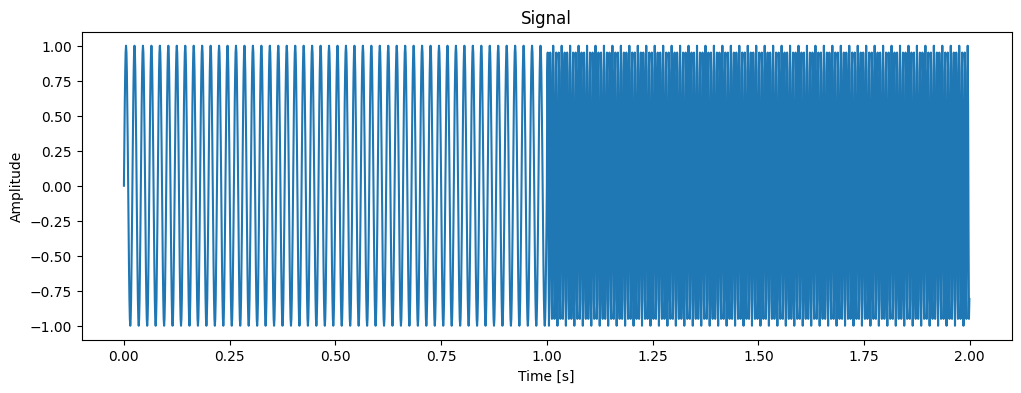

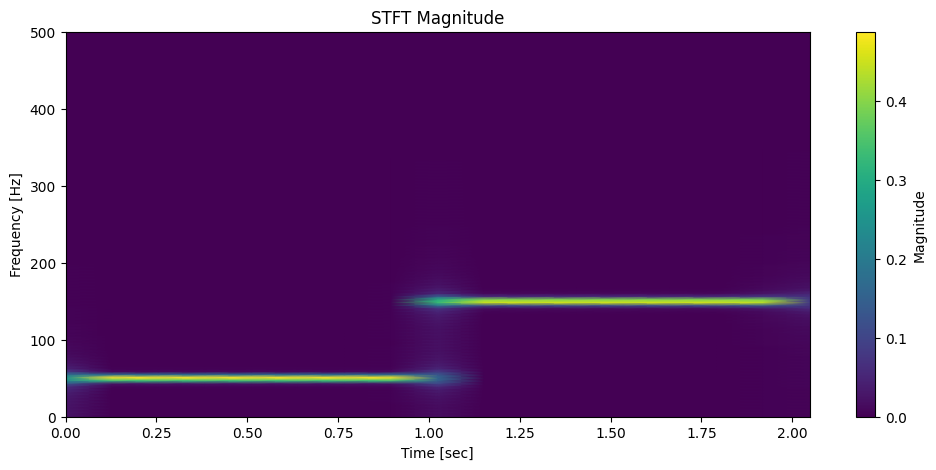

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import stft


# Generate a sample signal: two sine waves at different times
fs = 1000
T = 2


t = np.linspace(0, T, int(T*fs), endpoint=False)
signal = np.sin(2*np.pi*50*t) * (t < 1) + np.sin(2*np.pi*150*t) * (t >= 1)


# Compute STFT
f, tt, Zxx = stft(signal, fs=fs, nperseg=256)


# Plot signal
plt.figure(figsize=(12, 4))
plt.plot(t, signal)
plt.title("Signal")
plt.xlabel("Time [s]")
plt.ylabel("Amplitude")
plt.show()


# Plot spectrogram
plt.figure(figsize=(12, 5))
plt.pcolormesh(tt, f, np.abs(Zxx), shading='gouraud')
plt.title('STFT Magnitude')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.colorbar(label='Magnitude')
plt.show()

3. Continuous Wavelet Transform (CWT) — Theory

Wavelet analysis studies a signal using scaled and shifted copies of a small waveform called a mother wavelet. Unlike STFT, wavelets adapt their window size:

High frequencies → short windows (good time resolution)

Low frequencies → long windows (good frequency resolution)

This makes wavelets ideal for analyzing signals that change over time.

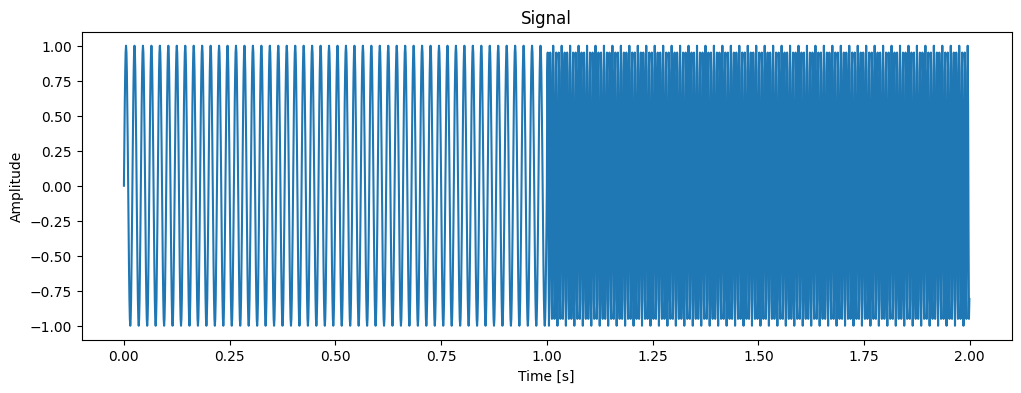

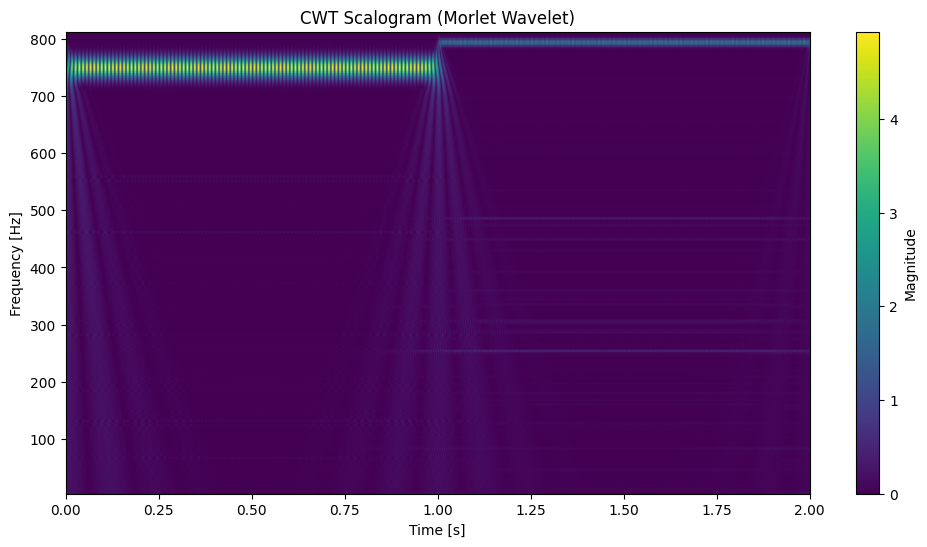

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pywt


# Generate a sample signal
fs = 1000
T = 2


t = np.linspace(0, T, int(T*fs), endpoint=False)
signal = np.sin(2*np.pi*50*t) * (t < 1) + np.sin(2*np.pi*150*t) * (t >= 1)


# Wavelet scales
scales = np.arange(1, 200)


# Compute CWT using Morlet wavelet
coeffs, freqs = pywt.cwt(signal, scales, 'morl', sampling_period=1/fs)


# Plot original signal
plt.figure(figsize=(12, 4))
plt.plot(t, signal)
plt.title("Signal")
plt.xlabel("Time [s]")
plt.ylabel("Amplitude")
plt.show()


# Plot CWT scalogram
plt.figure(figsize=(12, 6))
plt.imshow(np.abs(coeffs), extent=[0, T, freqs[-1], freqs[0]], aspect='auto')
plt.title("CWT Scalogram (Morlet Wavelet)")
plt.xlabel("Time [s]")
plt.ylabel("Frequency [Hz]")
plt.colorbar(label='Magnitude')
plt.show()

In [11]:
class Wavelet:
    def __init__(self,image):
        self.image = image
    
    def __down_sample(self,img):
        return img[::2, ::2]
    
    def __gaussian_kernel_1d(self,ksize=5, sigma=1.0):
        ax = np.arange(-ksize//2 + 1, ksize//2 + 1)
        kernel = np.exp(-0.5 * (ax / sigma)**2)
        kernel = kernel / kernel.sum()
        return kernel

    def __do_lowpass(self,img,ksize=7,sigma=1.5):
        g = self.__gaussian_kernel_1d(ksize, sigma)

        # Filter rows
        temp = np.apply_along_axis(lambda row: np.convolve(row, g, mode='same'),
                                axis=1, arr=img)

        # Filter columns
        out = np.apply_along_axis(lambda col: np.convolve(col, g, mode='same'),
                                axis=0, arr=temp)

        return out
    
    def __do_wavelet_one_level(self,image):
        low_pass=self.__do_lowpass(image)
        high_pass = np.abs(image - low_pass)

        return self.__down_sample(low_pass),self.__down_sample(high_pass)
    
    def do_wavelet(self,n_level = 2):
        low_img = self.image
        high_img = []
        for i in range(n_level):
            low_img,high=self.__do_wavelet_one_level(low_img)
            high_img.append(high)
        
        high_img.append(low_img)
        return high_img

def normalize_img(img):
    img_min = img.min()
    img_max = img.max()
    norm = (img - img_min) / (img_max - img_min)  # scale to 0-1
    return norm

def plot_wavelet_black_bg(components):
    n = len(components)
    plt.figure(figsize=(12, 3 * n))
    for i, comp in enumerate(components):
        plt.subplot(n, 1, i + 1)
        plt.imshow(normalize_img(comp), cmap='gray')
        if i < n - 1:
            plt.title(f"High-pass Level {i+1}")
        else:
            plt.title("Final Low-pass")
        plt.axis('off')
    plt.tight_layout()
    plt.show()


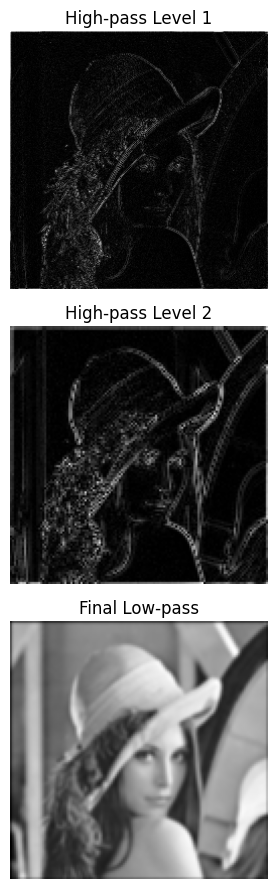

In [12]:
from PIL import Image
import numpy as np

# Read image as grayscale
img = Image.open('image.png').convert('L')  # 'L' = grayscale
img = np.array(img, dtype=np.float32)

w = Wavelet(img)
components = w.do_wavelet(n_level=2)  # change number of levels if you want

plot_wavelet_black_bg(components)

In [13]:
import numpy as np
from scipy.signal import convolve2d

class Wavelet:
    def __init__(self, image):
        self.image = image.astype(np.float32)
        # Normalize to [0,1] if it's uint8
        if self.image.max() > 1.0:
            self.image = self.image / 255.0
    
    def __down_sample(self, img):
        return img[::2, ::2]
    
    def __up_sample(self, img):
        """Upsample by factor 2: insert zeros and compensate energy (×4)"""
        h, w = img.shape
        up = np.zeros((h*2, w*2), dtype=np.float32)
        up[::2, ::2] = img * 4.0   # ×4 because we lost 3/4 of energy when downsampling
        return up

    def __do_subbands_one_level(self, image):
        # Low-pass filter (simple Gaussian-like, symmetric)
        g = np.array([[1, 2, 1],
                      [2, 4, 2],
                      [1, 2, 1]], dtype=np.float32) / 16.0

        # Analysis high-pass filters (Sobel-like, made zero-mean and normalized)
        k_h = np.array([[-1, -2, -1],
                        [ 0,  0,  0],
                        [ 1,  2,  1]], dtype=np.float32) / 8.0   # horizontal edges
        k_v = np.array([[-1, 0, 1],
                        [-2, 0, 2],
                        [-1, 0, 1]], dtype=np.float32) / 8.0   # vertical edges
        k_d = np.array([[ 0,  1,  2],
                        [-1,  0,  1],
                        [-2, -1,  0]], dtype=np.float32) / 8.0   # diagonal

        # Analysis: convolve with filters
        LL = convolve2d(image, g,  mode='same', boundary='symm')
        LH = convolve2d(image, k_h, mode='same', boundary='symm')
        HL = convolve2d(image, k_v, mode='same', boundary='symm')
        HH = convolve2d(image, k_d, mode='same', boundary='symm')

        # Downsample all subbands
        LL = self.__down_sample(LL)
        LH = self.__down_sample(LH)
        HL = self.__down_sample(HL)
        HH = self.__down_sample(HH)

        return LL, LH, HL, HH

    def do_wavelet(self, n_level=2):
        current = self.image
        coeffs = []

        for _ in range(n_level):
            LL, LH, HL, HH = self.__do_subbands_one_level(current)
            coeffs.append((LH, HL, HH))   # detail coefficients
            current = LL                  # approximation for next level

        coeffs.append(current)  # final approximation
        return coeffs

    # ================ CORRECT RECONSTRUCTION =================
    def reconstruct(self, subbands):
        """
        Perfect reconstruction from the custom wavelet coefficients.
        subbands: list returned by do_wavelet()
        """
        # Synthesis filters = analysis filters because they are symmetric / we normalized properly
        g_syn = np.array([[1, 2, 1],
                          [2, 4, 2],
                          [1, 2, 1]], dtype=np.float32) / 16.0

        k_h_syn = np.array([[-1, -2, -1],
                            [ 0,  0,  0],
                            [ 1,  2,  1]], dtype=np.float32) / 8.0

        k_v_syn = np.array([[-1,  0,  1],
                            [-2,  0,  2],
                            [-1,  0,  1]], dtype=np.float32) / 8.0

        k_d_syn = np.array([[ 0,  1,  2],
                            [-1,  0,  1],
                            [-2, -1,  0]], dtype=np.float32) / 8.0

        current = subbands[-1].copy()  # start from coarsest LL

        # Go from coarsest to finest
        for i in reversed(range(len(subbands)-1)):
            LH, HL, HH = subbands[i]

            # Upsample all four subbands (×4 inside __up_sample)
            LL_up = self.__up_sample(current)
            LH_up = self.__up_sample(LH)
            HL_up = self.__up_sample(HL)
            HH_up = self.__up_sample(HH)

            # Apply synthesis filters
            recon_LL = convolve2d(LL_up, g_syn,     mode='same', boundary='symm')
            recon_LH = convolve2d(LH_up, k_h_syn,   mode='same', boundary='symm')
            recon_HL = convolve2d(HL_up, k_v_syn,   mode='same', boundary='symm')
            recon_HH = convolve2d(HH_up, k_d_syn,   mode='same', boundary='symm')

            # Sum the four contributions
            current = recon_LL + recon_LH + recon_HL + recon_HH

        # Clip to valid range (in case of floating-point imprecision)
        reconstructed = np.clip(current, 0.0, 1.0)
        return reconstructed

In [14]:
import matplotlib.pyplot as plt
def normalize_img(img):
    return (img - img.min()) / (img.max() - img.min())

def plot_wavelet_subbands(components):
    """
    Plot all wavelet subbands with black background.
    components: list of tuples [(LH, HL, HH), ... final_LL]
    """
    n_levels = len(components) - 1  # last element is final LL
    plt.figure(figsize=(12, 3 * (n_levels)))

    for i, comp in enumerate(components):
        if i < n_levels:
            LH, HL, HH = comp
            # Plot LH, HL, HH horizontally for this level
            plt.subplot(n_levels, 3, i*3 + 1)
            plt.imshow(normalize_img(LH), cmap='gray')
            plt.title(f"Level {i+1} LH")
            plt.axis('off')

            plt.subplot(n_levels, 3, i*3 + 2)
            plt.imshow(normalize_img(HL), cmap='gray')
            plt.title(f"Level {i+1} HL")
            plt.axis('off')

            plt.subplot(n_levels, 3, i*3 + 3)
            plt.imshow(normalize_img(HH), cmap='gray')
            plt.title(f"Level {i+1} HH")
            plt.axis('off')
        else:
            # Last component: final LL
            plt.subplot(n_levels, 3, 3*n_levels//2 + 1)
            plt.imshow(normalize_img(comp), cmap='gray')
            plt.title("Final LL")
            plt.axis('off')

    plt.tight_layout()
    plt.show()
    


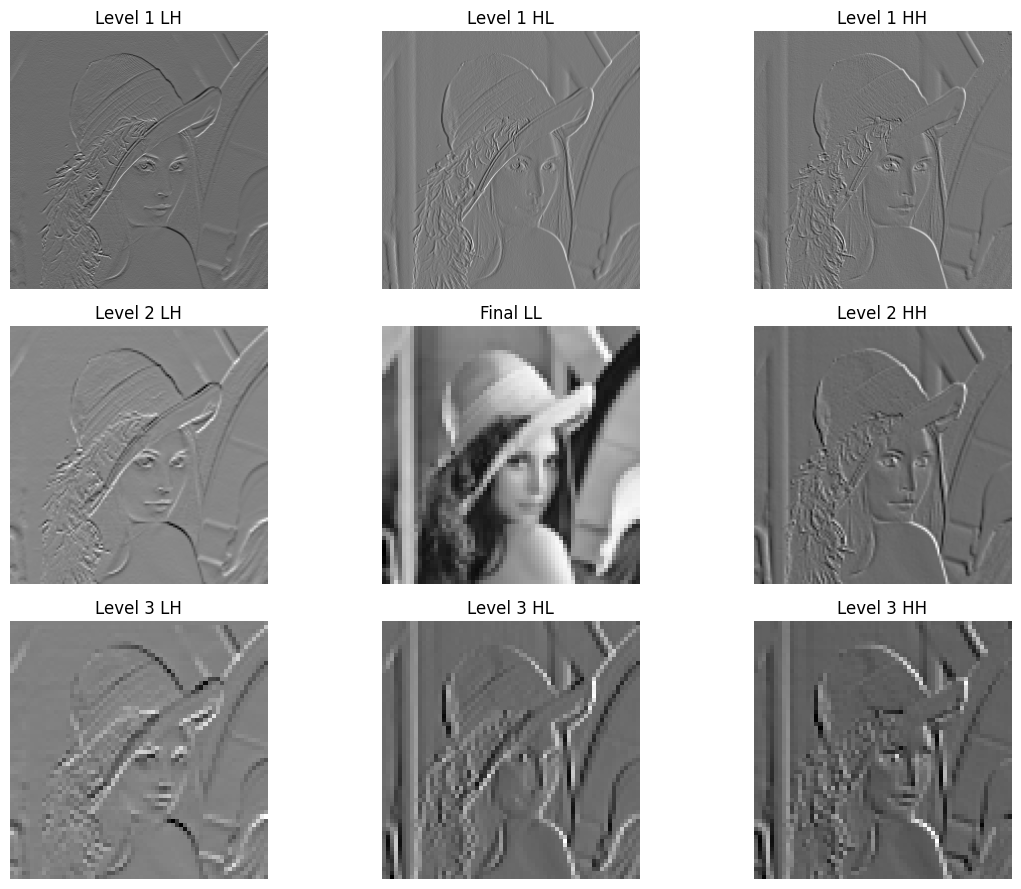

In [15]:
from PIL import Image
import numpy as np

# Read image as grayscale
img = Image.open('image.png').convert('L')  # 'L' = grayscale
img = np.array(img, dtype=np.float32)

w = Wavelet(img)
components = w.do_wavelet(n_level=3)  # change number of levels if you want

plot_wavelet_subbands(components)

In [16]:
w = Wavelet(img)
subbands = w.do_wavelet(n_level=3)
subbands[-1] = subbands[-1]*0
reconstructed = w.reconstruct(subbands)

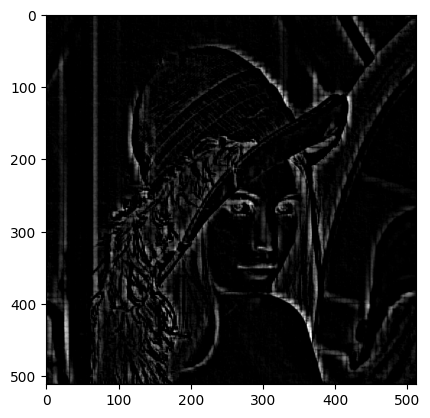

In [17]:
plt.imshow(reconstructed,cmap='gray')
plt.show()

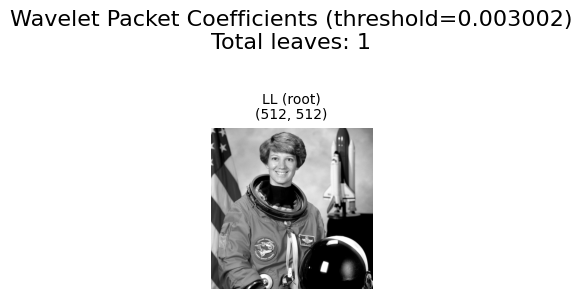

In [20]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import convolve2d
from skimage.data import astronaut   # or use your own image

# --------------------- WaveletPacket class (same as before) ---------------------
class WaveletPacket:
    def __init__(self, image, threshold=0.0005):
        self.image = image.astype(np.float32)
        if self.image.max() > 1.0:
            self.image /= 255.0
        self.threshold = threshold

        self.g = np.array([[1,2,1],[2,4,2],[1,2,1]], dtype=np.float32) / 16.0
        self.k_h = np.array([[-1,-2,-1],[0,0,0],[1,2,1]], dtype=np.float32) / 8.0
        self.k_v = np.array([[-1,0,1],[-2,0,2],[-1,0,1]], dtype=np.float32) / 8.0
        self.k_d = np.array([[0,1,2],[-1,0,1],[-2,-1,0]], dtype=np.float32) / 8.0

    def __downsample(self, x): return x[::2, ::2]
    def __upsample(self, x):
        h, w = x.shape
        up = np.zeros((h*2, w*2), dtype=np.float32)
        up[::2, ::2] = x * 4.0
        return up

    def __analyze_one_level(self, img):
        LL = convolve2d(img, self.g,     mode='same', boundary='symm')
        LH = convolve2d(img, self.k_h,   mode='same', boundary='symm')
        HL = convolve2d(img, self.k_v,   mode='same', boundary='symm')
        HH = convolve2d(img, self.k_d,   mode='same', boundary='symm')
        return [self.__downsample(b) for b in (LL, LH, HL, HH)]

    def decompose(self, max_depth=6):
        def recurse(block, depth):
            if depth >= max_depth:
                return block
            sub = self.__analyze_one_level(block)
            vars_detail = [np.var(sub[i]) for i in (1,2,3)]
            if all(v < self.threshold for v in vars_detail):
                return block                      # stop splitting
            return [recurse(sub[i], depth+1) for i in range(4)]

        self.tree = recurse(self.image, 0)
        return self.tree

    # --------------------- Collect and plot only the final leaves ---------------------
    def collect_leaves(self, tree=None):
        if tree is None:
            tree = self.tree
        leaves = []
        labels = []

        def traverse(node, path=""):
            if isinstance(node, np.ndarray):
                leaves.append(node)
                labels.append(path if path else "LL (root)")
                return
            for i, child in enumerate(node):
                code = ["LL", "LH", "HL", "HH"][i]
                traverse(child, path + code if path else code)
        traverse(tree)
        return leaves, labels

    def plot_all_coefficients(self):
        leaves, labels = self.collect_leaves()
        n = len(leaves)
        if n == 0:
            print("No leaves found!")
            return

        cols = int(np.ceil(np.sqrt(n)))
        rows = int(np.ceil(n / cols))

        plt.figure(figsize=(cols*3, rows*3))
        global_min = min([np.percentile(leaf, 1) for leaf in leaves])
        global_max = max([np.percentile(leaf, 99) for leaf in leaves])

        for i, (coeff, label) in enumerate(zip(leaves, labels)):
            plt.subplot(rows, cols, i+1)
            plt.imshow(coeff, cmap='gray', vmin=global_min, vmax=global_max)
            plt.title(f"{label}\n{coeff.shape}", fontsize=10)
            plt.axis('off')
        plt.suptitle(f"Wavelet Packet Coefficients (threshold={self.threshold})\n"
                     f"Total leaves: {n}", fontsize=16)
        plt.tight_layout(rect=[0, 0, 1, 0.95])
        plt.show()


# --------------------- Run it ---------------------
img = astronaut()
gray = img.mean(axis=2) / 255.0   # or load your own image here

wp = WaveletPacket(gray, threshold=0.003002)   # play with this value!
wp.decompose(max_depth=7)

# This is the only thing you asked for:
wp.plot_all_coefficients()

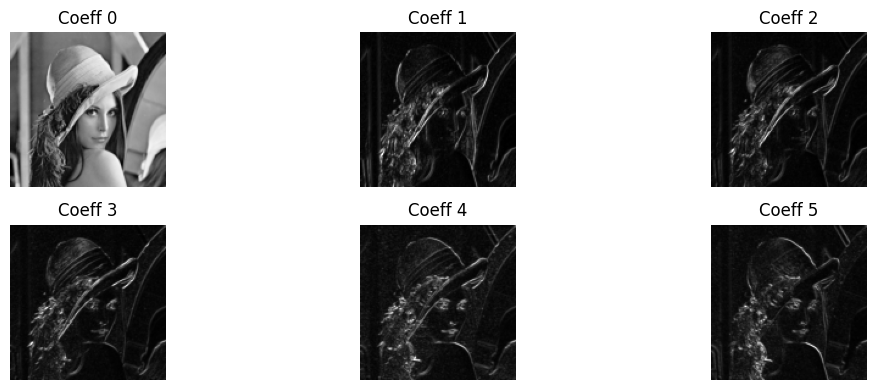

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from kymatio.numpy import Scattering2D
from skimage import io, color

# Load image
img = io.imread('image.png')
if img.ndim == 3:
    img = color.rgb2gray(img)
img = img.astype(np.float32)

# Create scattering object
J = 2  # number of scales
shape = img.shape
scattering = Scattering2D(J=J, shape=shape)

# Compute scattering coefficients
S = scattering(img)

# S is a numpy array: shape (C, H_s, W_s)  
# C = number of scattering coefficients

# Plot a few coefficients
C, Hs, Ws = S.shape
plt.figure(figsize=(12, 4))

# Choose some coefficient indices to plot (for example first few)
for i in range(min(6, C)):
    plt.subplot(2, 3, i + 1)
    plt.imshow(S[i], cmap='gray')
    plt.title(f'Coeff {i}')
    plt.axis('off')

plt.tight_layout()
plt.show()


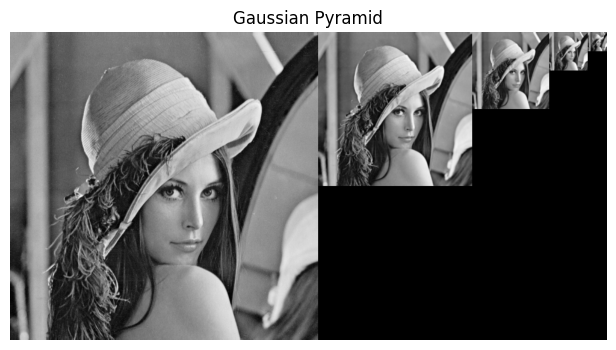

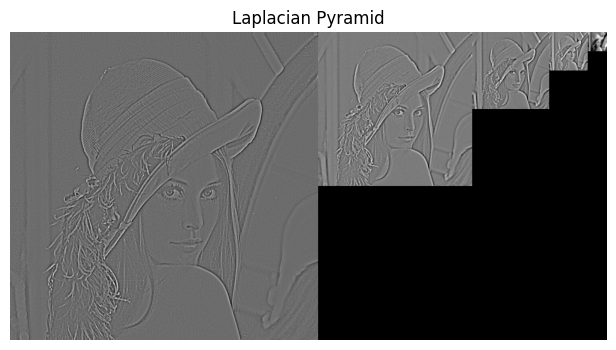

In [21]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def gaussian_pyramid(image, levels=4):
    pyramid = [image.astype(np.float32)]
    current = image.copy().astype(np.float32)
    for _ in range(1, levels):
        current = cv2.pyrDown(current)
        pyramid.append(current)
    return pyramid

def laplacian_pyramid(image, levels=4):
    g_pyr = gaussian_pyramid(image, levels)
    l_pyr = []
    for i in range(levels-1):
        next_up = cv2.pyrUp(g_pyr[i+1], dstsize=(g_pyr[i].shape[1], g_pyr[i].shape[0]))
        lap = g_pyr[i] - next_up
        l_pyr.append(lap)
    l_pyr.append(g_pyr[-1])
    return l_pyr

def plot_pyramid(pyramid, title="Pyramid"):
    """
    Plot a pyramid structure showing decreasing sizes.
    pyramid: list of 2D arrays (each level)
    """
    max_h = pyramid[0].shape[0]
    total_w = sum([p.shape[1] for p in pyramid])
    
    # Create blank canvas
    canvas = np.zeros((max_h, total_w), dtype=np.float32)
    
    x_offset = 0
    for p in pyramid:
        h, w = p.shape
        # top-align each level
        canvas[:h, x_offset:x_offset+w] = (p - p.min()) / (p.max() - p.min())
        x_offset += w
    
    plt.figure(figsize=(12,4))
    plt.imshow(canvas, cmap='gray')
    plt.title(title)
    plt.axis('off')
    plt.show()

# Example usage
img = cv2.imread('image.png', cv2.IMREAD_GRAYSCALE)

g_pyr = gaussian_pyramid(img, levels=5)
l_pyr = laplacian_pyramid(img, levels=5)

plot_pyramid(g_pyr, title="Gaussian Pyramid")
plot_pyramid(l_pyr, title="Laplacian Pyramid")


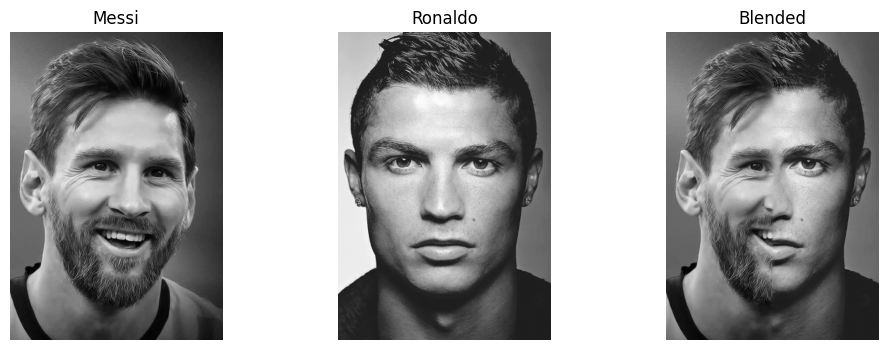

In [22]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def gaussian_pyramid(img, levels):
    gp = [img.astype(np.float32)]
    for _ in range(levels - 1):
        img = cv2.pyrDown(img)
        gp.append(img.astype(np.float32))
    return gp

def laplacian_pyramid(img, levels):
    gp = gaussian_pyramid(img, levels)
    lp = []
    for i in range(levels - 1):
        size = (gp[i].shape[1], gp[i].shape[0])
        up = cv2.pyrUp(gp[i+1], dstsize=size)
        lap = cv2.subtract(gp[i], up)
        lp.append(lap)
    lp.append(gp[-1])  # last level
    return lp

def blend_pyramids(lp1, lp2, gp_mask):
    blended = []
    for l1, l2, gm in zip(lp1, lp2, gp_mask):
        blended.append(l1 * gm + l2 * (1.0 - gm))
    return blended

def reconstruct_from_pyramid(lp):
    image = lp[-1]
    for i in range(len(lp)-2, -1, -1):
        size = (lp[i].shape[1], lp[i].shape[0])
        image = cv2.pyrUp(image, dstsize=size)
        image = cv2.add(image, lp[i])
    return image

# --- Read images as grayscale ---
img1 = cv2.imread('messi.png', cv2.IMREAD_GRAYSCALE)
img2 = cv2.imread('ronaldo.png', cv2.IMREAD_GRAYSCALE)

# Resize to same size
h, w = img1.shape[:2]
img2 = cv2.resize(img2, (w, h))

# Mask: left half = 1, right half = 0
mask = np.zeros((h, w), dtype=np.float32)
mask[:, :w//2] = 1.0

levels = 6

# Build pyramids
gp_mask = gaussian_pyramid(mask, levels)
lp1 = laplacian_pyramid(img1, levels)
lp2 = laplacian_pyramid(img2, levels)

# Blend
blended_lp = blend_pyramids(lp1, lp2, gp_mask)
blended_img = reconstruct_from_pyramid(blended_lp)

# Clip and convert
blended_img = np.clip(blended_img, 0, 255).astype(np.uint8)

# Show results
plt.figure(figsize=(12,4))
plt.subplot(1,3,1)
plt.imshow(img1, cmap='gray')
plt.title('Messi')
plt.axis('off')

plt.subplot(1,3,2)
plt.imshow(img2, cmap='gray')
plt.title('Ronaldo')
plt.axis('off')

plt.subplot(1,3,3)
plt.imshow(blended_img, cmap='gray')
plt.title('Blended')
plt.axis('off')
plt.show()


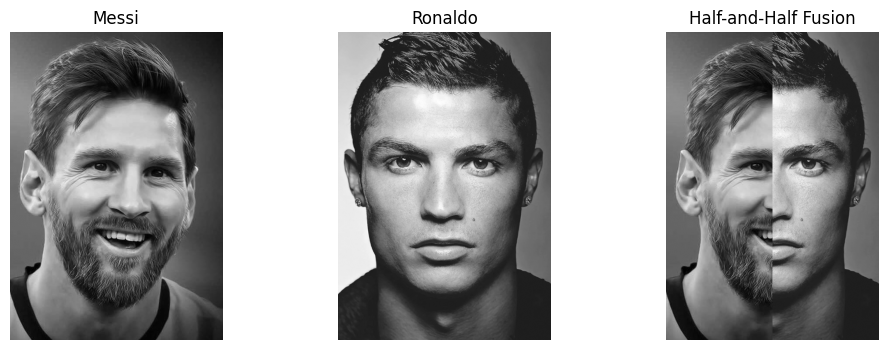

In [23]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Read images as grayscale
img1 = cv2.imread('messi.png', cv2.IMREAD_GRAYSCALE)
img2 = cv2.imread('ronaldo.png', cv2.IMREAD_GRAYSCALE)

# Resize second image to match first
h, w = img1.shape
img2 = cv2.resize(img2, (w, h))

# Simple half-and-half fusion
cut = w // 2
fused = np.zeros_like(img1)
fused[:, :cut] = img1[:, :cut]    # left half from Messi
fused[:, cut:] = img2[:, cut:]    # right half from Ronaldo

# Show
plt.figure(figsize=(12,4))
plt.subplot(1,3,1)
plt.imshow(img1, cmap='gray')
plt.title('Messi')
plt.axis('off')

plt.subplot(1,3,2)
plt.imshow(img2, cmap='gray')
plt.title('Ronaldo')
plt.axis('off')

plt.subplot(1,3,3)
plt.imshow(fused, cmap='gray')
plt.title('Half-and-Half Fusion')
plt.axis('off')
plt.show()
